# The Variational Principle

$$ \hat{H}\psi = E\psi $$

$$ [-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}+V(x)]\psi=E\psi $$

All the imports

In [1]:
import matplotlib.pyplot as plt
import numpy
from scipy import integrate

Set the value of $\hbar$ and $m$ used in the Schrodinger Equation and calculate the 
value of $-\frac{\hbar^2}{2m}$ as it's reused constantly in calculations.

Values taken from Wikipedia:
* $\hbar$: https://en.wikipedia.org/wiki/Planck_constant
* $m$: https://en.wikipedia.org/wiki/Electron

In [2]:
# h_bar = 1
# h_bar = 1.054571817 * 10 **-34 	#J⋅s
h_bar = 6.582119569 * 10 ** -16   #eV.s


# m = 1
m = 9.1093837015 *10**-31 #kg (from wikipedia)

factor = -h_bar**2 / (2 * m)

Define the potential function, it is a scalar function that has the same length as 
the given $\bar{r}$

Create sub potential functions that can be implemented in the main function for 
analytically solved examples:

In [3]:
def free_particle(r : numpy.ndarray):
    """
    The free particle potential represents an unbound particle in zero potential.
    :param r: The coordinates of the potential values
    :return: The free particle potential.
    """
    # The free particle has no potential.
    return numpy.zeros(len(r))

In [ ]:
def finite_square_well(r : numpy.ndarray, V_0 : float, *wall_bounds : int):
    """
    The infinite square well has defined potential within the bounds.
    :param r: The coordinates of the potential values.
    :param V_0: The potential value outside of the well
    :param wall_bounds: The points at which the well boundary starts. 
    :return: The infinite potential well function. 
    """
    # Get the number of points along the axis
    num_points = len(r)
    # The first number in wall_bounds is the index of the first well wall
    lower = wall_bounds[0]
    # the index of the second wall is the second index in wall_bounds 
    upper = wall_bounds[1]
    
    # Create the potential barrier of the well.
    lower_wall = numpy.array([V_0] * lower)
    # inside the well the potential is 0
    zeroes = numpy.zeros(num_points - lower - upper)
    # second potential barrier
    upper_wall = numpy.array([V_0] * upper)
    # Make the potential the combination of all the sections
    pot = numpy.concatenate((lower_wall, zeroes, upper_wall))
    
    return pot


In [4]:
def infinite_square_well(r : numpy.ndarray, *wall_bounds : int):
    """
    The infinite square well has defined potential within the bounds.
    :param r: The coordinates of the potential values.
    :param wall_bounds: The points at which the well boundary starts.
    :return: The infinite potential well function.
    """
    # Use the finite square well with infinite barriers.
    return finite_square_well(r, numpy.inf, wall_bounds)

In [5]:
def harmonic_oscillator(r : numpy.ndarray, k : float):
    """
    The Harmonic Oscillator potential is quadratic about the origin.
    :param r: The coordinates of the potential values.
    :param k: Hooke's constant for the system
    :return: The harmonic potential.
    """
    # The potential energy formula:
    return 0.5 * k * r**2

In [6]:
def potential(r :numpy.ndarray):
    """
    The potential energy function of the system.
    :param r: The points on the axes of the system. 
    :return: A scalar ndarray of the values of the potential at each point in r. 
    """
    
    return harmonic_oscillator(r, 0.01)

Define the Hamiltonian operator from the Schrodinger Equation:

$$\hat{H} = -\frac{\hbar^2}{2m}\nabla^2+V(x)$$

where 

$$\nabla^2=\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} + \frac{\partial^2}{\partial z^2}$$

In [7]:
# V is the potential,
# psi is the wavefunction
def hamiltonian(V :numpy.ndarray):
    """
    Returns the Hamiltonian Operator H for a given potential function V.
    
    :param V: The potential function of the system.
    :return: The Hamiltonian operator H of the system.
    """
    
    # The grad() function to take derivatives of the given wavefunction
    grad = numpy.gradient
    
    # In order to make the hamiltonian an operator, need to return a function 
    # that can be the operator
    
    # placeholder function to be returned, takes in the wavefunction as it's parameter
    def foo(psi :numpy.ndarray):
        """
        The Hamiltonian Operator H, operates on the given wavefunction psi according
        to the Schrodinger Time Indepedent Equation:
        H = -(hbar^2)/(2m) * d^2/dx^2 + V(x)
        :param psi: The wavefunction of the system.
        :return: The energy E of the wavefunction.
        """
        # Since the Hamiltonian represents the Energy of the system, it can be split 
        # into the potential energy (V) and kinetic energy (T) 
        
        # The potential energy combined with the wavefunction.
        Vp = V * psi
        # The kinetic energy operated on the waefunction, using the pre-calculated
        # factor of -hbar^2 / 2m.
        Tp = factor * grad(grad(psi))
        # H = Tp + Vp
        return Tp + Vp
    # return the operator function
    return foo

The normalisation condition for $\psi$ id that:

$$\int|\psi|^2dx=1$$

for a given non-normalised wavefunction the condition is:

$$\int{|\psi|^2dx}=A^2$$ for some constant $A$.

Thus the normalised $\psi_0$ is given by: $\psi_0=\frac{\psi}{A}$. 

In [8]:
def normalise_psi(psi: numpy.ndarray):
    """
    Normalises the given wavefunction so that it's magnitude integrated over it's 
    extent is 1.
    :param psi: The wavefunction to normalise
    :return: A normalised ndarray of the wavefunction psi.
    """
    # Can't use:
    # norm = expectation_value(lambda p: p, psi)
    # Due to recursive loop, solution is to make this function 
    # stand alone.

    # Get the complex conjugate of the wavefunction
    psi_star = psi.conj()
    # Get the magnitude of the wavefunction by multiply the original and conjugate
    # parts.
    mag_psi = psi_star * psi

    # Get the integration of this magnitude
    norm = integrate.romb(mag_psi)
    
    # Normalise the wavefunction by the square root of the norm.
    norm_psi = psi / numpy.sqrt(norm)

    return norm_psi

Function to evaluate the general expectation value $< Q >$ for a given operator 
$Q(\bar{r}, \hat\rho)$ according to the condition:

$$\int{\psi^*\hat{Q}\psi dr}= < Q >$$

In [9]:
def expectation_value(Q, psi: numpy.ndarray):
    """
    Calculates the general expectation <Q> for the general operator Q.
    :param Q: Any operator on psi. 
    :param psi: The wavefunction to operate on
    :return: The expectation <Q> of the operator.
    """
    # TODO: add check for if it's already normalised?
    # may be more efficient when large arrays are involved
    psi = normalise_psi(psi)
    # Get the complex conjugate of the wavefunction
    psi_star = psi.conjugate()
    # The condition to integrate
    integrand = psi_star * Q(psi)

    return integrate.romb(integrand)

Calculate the $< E >$ energy expectation value using the hamiltonian operator $\hat H$.

In [10]:
def energy_expectation(psi :numpy.ndarray):
    """
    Calculates the expectation value for the energy of the given wavefunction 
    representing a particle.
    :param psi: The wavefunction to get the energy of.
    :return: The <E> a scalar of the energy of the particle in the system.
    """
    # Get the potential of the system
    V = potential(x)
    # Get the Hamiltonian of the system
    H = hamiltonian(V)
    # Calculate <H> which is the equivalent to <E>
    return expectation_value(H, psi)

# Dimensionless Schrodinger Equation
 ---
 https://www.finetuningphysics.com/equations/dimensionless-schrodinger-equation
 

Summarised:
1. We start off by defining the following quantities:
    1. $\ell_a = \frac{\hbar}{m_e c} $
    * $t_a = \frac{\hbar}{m_e c^2}$
    * $E_a = m_e c^2$
* which allows us to rewrite relevant quantities in a dimensionless form, as follows:
    1. $\tau = \frac{t}{t_a}$
    * $\bar{\rho}=\frac{\bar{r}}{\ell_a}$
    * $\varepsilon = \frac{E}{E_a}$
    * $\mu_i=\frac{m_i}{m_e}$
* Thus we can rewrite the Schrodinger Equation as:
     $$i\frac{\partial}{\partial t}\psi(\bar{\rho}, \tau)=-(\frac{1}{2}\frac{m_e}{m}\nabla^2 + V)\psi(\bar{\rho}, \tau)$$

$$[-\frac{\hbar^2}{2m}\nabla^2+V]\psi(x)=E\psi(x)$$


In [11]:
c = 299792458 # speed of light

l_a = h_bar / (m * c)
t_a = h_bar / (m * c**2)
E_a = m * c**2

# tau = t/t_a
# rho = r / l_a
# rho = x / l_a
# epsilon = E / E_a
# mu_i = m_i / m_e

# Definitions:

The bounds for the problem

_x_min_ is the minimum value of x,

_x_max_ is the maximum value of x,

_x_step_ is the spacing between values,

_number _samples_ is the integer to define
the total number of samples to take, actual value is
$2^n +1 $ 

In [12]:
x_min = -20
x_max = -x_min
n = 10
number_samples = 2**n + 1 # for romberg integration
x_step = (x_max - x_min) / number_samples # make the step accurate

Calculate the _x_ variable

In [13]:
x = numpy.linspace(x_min, x_max, number_samples)

In [14]:
def tweak_psi(psi, index, amount):
    """
    A function to change the value of the wavefunction at a given coordinate by a given
    amount.
    :param psi: The wavefunction to modify. 
    :param index: The coordinate in the wavefunction to modify.
    :param amount: The amount to modify by.
    :return: A new wavefunction modified by the desired amount.
    """
    # Create a copy of the wavefunction as the ndarray is mutable.
    new_psi = psi.copy()
    # Change the value at index by the desired amount.
    new_psi[index] += amount
    # return the new wavefunction
    return new_psi

Initial calculation of the optimum ground state wavefunction for the given potential
using a randomisation method

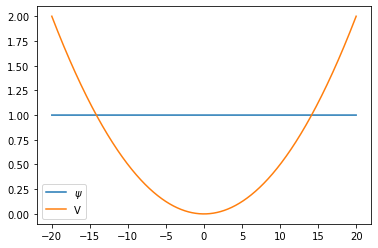

KeyboardInterrupt: 

In [15]:
# Use ramdom for random generation of numbers
import random

# The number of times to generate a random number.
# number_iterations = 5000
# number_iterations = 1000
number_iterations = 50000
# number_iterations = 5000000

# Set the default wavefunction
psi = numpy.linspace(1, 1, number_samples)

# Plot the wavefunction versus the potential for visualisation
plt.plot(x, psi)
plt.plot(x, potential(x))
plt.legend(("$\psi$", "V"))
plt.show()

# Set the seed to be as desired, so that the results are repeatable.
seed = "The Variational Principle"
# Get the random number generator.
rand = random.seed(seed)

# Iterate for the number of desired iterations
for i in range(number_iterations):
    
    # Get a random x coord to sample
    rand_x = random.randrange(0, number_samples)
    
    # Generate a random number to alter the entry by.
    rand_tweak = random.random()
    
    # Alter the entry up and down
    psi_up = tweak_psi(psi, rand_x, +rand_tweak)
    psi_down = tweak_psi(psi, rand_x, -rand_tweak)
    
    # Get the corresponding energies for the tweaks
    E_up = energy_expectation(psi_up)
    E_down = energy_expectation(psi_down)
    
    # Get the current energy for reference.
    E = energy_expectation(psi)
    
    # Compare the Energies for the new tweaks, keep the one that
    # produces a lower overall expectation energy.
    if E_up < E_down and E_up < E:
        psi = psi_up
    elif E_down < E_up and E_down < E:
        psi = psi_down

# Normalise the final wavefunction
psi = normalise_psi(psi)

# plot the final wavefunction. 
plt.plot(x, psi)
# plt.plot(x, potential(x))
plt.show()
   

In [ ]:
# Keep the wavefunction generated for reference.
saved_psi = psi

Perform Fourier Analysis on the produced wavefunction to reduce the noise on the
solution.

In [ ]:
# Get the Fast Fourier Transform package
import scipy.fftpack as fftpack

# Get the saved psi 
psi = saved_psi

# Do the FT on the wavefunction
fft_psi = fftpack.fft(psi)
# Half the produced value as the FT is symmetric
fft_psi = fft_psi[:int(len(fft_psi) / 2)]
# plt.plot(x, fft_psi)

# Plot the FT to visualise the results.
plt.plot(fft_psi)
plt.show()

# Chop the FT to keep only the most important harmonics
fft_psi = fft_psi[:25]
# Plot the minimised FT
plt.plot(fft_psi)
plt.show()

#Perform an inverse FT to get the smoothed wavefunction back
psi = fftpack.ifft(fft_psi)

# len_psi = len(psi)
# print(len_psi)
# 
# len_less_1 = len_psi - 1
# print(len_less_1)
# 
# log_2 = numpy.log2(len_less_1)
# print(log_2)
# k = int(numpy.ceil(log_2))
# power = 2**k +1
# print(power)
# diff = power - len_psi
# print(diff)
# addition = numpy.zeros(diff)
# print(addition)
# 
# psi = numpy.concatenate((psi, addition))
# print(len(psi))

# Normalise the result
psi_conj = psi.conj()
mod_psi = psi_conj * psi
A = numpy.sqrt(integrate.simps(mod_psi))
psi /= A

# psi = normalise_psi(psi)

# Plot the final wavefunction to show the result.   
x_range = numpy.linspace(x_min, x_max, len(psi))
plt.plot(x_range, psi)
plt.title("Smoothed Wavefunction $\psi$")
plt.xlabel("x")
plt.ylabel("$\psi$")
plt.show()
